In [1]:
pip install transformers torch scikit-learn nltk tensorflow


Note: you may need to restart the kernel to use updated packages.


# Using transfoermers with BERT from HuggingFace to detect anomalies in logs 

In the context of using BERT for anomaly detection, BERT itself does not directly use the self-attention mechanism for the anomaly detection step. Instead, it leverages its pre-trained capabilities to generate rich, context-aware embeddings of the log entries or text data. The self-attention mechanism in BERT is used during the embedding generation phase to create these contextual embeddings.

## BERT’s Role in Anomaly Detection

### Self-Attention in BERT

Self-Attention Mechanism: 

During the initial training and fine-tuning phases, BERT uses self-attention to understand the context of each word in a sentence. This mechanism allows BERT to create embeddings that capture the meaning and relationships between words.
Embedding Generation: When we input log entries into BERT, it uses its self-attention mechanism to produce embeddings for each log entry. These embeddings contain contextual information about the logs.

### Anomaly Detection Using BERT Embeddings

Embedding Usage: 

The embeddings generated by BERT are then used as input to an anomaly detection algorithm. This part does not involve self-attention but relies on the rich information captured by the embeddings.
Anomaly Detection Algorithm: Common algorithms for detecting anomalies in the embeddings include clustering  density-based methods (e.g., DBSCAN)

In [1]:
from transformers import BertTokenizer, BertModel
import torch


'''
Function: get_model_and_tokenizer
Objective: This function returns the BERT model and tokenizer
Input: None
Output: model, tokenizer
'''
def get_model_and_tokenizer():
    # Load BERT tokenizer and model
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertModel.from_pretrained('bert-base-uncased')
    model.eval()
    return  model, tokenizer

'''
Function: get_embeddings
objective: This function returns the embeddings of the input log entries
Input: log_entries, model, tokenizer, max_length
    log_entries: list of log entries
    model: BERT model
    tokenizer: BERT tokenizer
    max_length: maximum length of the input log entries. If the length of the log entry 
                is greater than max_length, it will be truncated to avold memory issues.
Output: embeddings
'''
def get_embeddings(log_entries, model, tokenizer, max_length = 128):
    # Tokenize input
    input_ids = tokenizer(log_entries, return_tensors='pt', padding=True, truncation=True, max_length=max_length)
    # Get embeddings
    with torch.no_grad():
        output = model(input_ids=input_ids['input_ids'],
                       attention_mask=input_ids['attention_mask'], 
                       token_type_ids=input_ids['token_type_ids'])

    embeddings = output.last_hidden_state
    return embeddings

c:\Users\HP\OneDrive\Documents\Eduardo Toledo\ASAI\log_analytics\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Logs Preprocessing


In [2]:
import os
import glob
import nltk
from nltk.tokenize import word_tokenize
import re

'''
Function: read_logs
Objective: This function reads log entries from log files in the current directory
Input: file_list (optional). List of log files to read. 
    If None, all log files in the current directory will be read.
Output: log_entries. List of log entries read from the log files.
'''
def read_logs(file_list=None):
    log_entries = []
    directory = os.getcwd()  # Get the current working directory
    if file_list is None:
        file_paths = glob.glob(os.path.join(directory, "*.jrn"))
    else:
        file_paths = [os.path.join(directory, file) for file in file_list]
    for file_path in file_paths:
        with open(file_path, 'r') as file:
            lines = file.readlines()
            log_entries.extend(lines)
    return log_entries

'''
    Function: preprocess_logs
    Objective: This function preprocesses log entries by removing timestamps, operation codes, special characters, and numbers.
                It also tokenizes the log entries into words and filters out non-readable words.
    Input: log_entries. List of log entries to preprocess.
    Output: processed_logs. List of preprocessed log entries.
'''
def preprocess_logs(log_entries):
    processed_logs = []
    for entry in log_entries:
        # Simplify whitespace and strip newlines
        entry = entry.strip().replace("\n", "")
        # Remove leading timestamps and operation codes
        entry = re.sub(r"^\s*\d{2}:\d{2}:\d{2}\s+\d+\s+", "", entry)
        # Remove special formatting characters and digits clustered as error codes or IDs
        entry = re.sub(r"\d{2,}", "", entry)  # removes long sequences of digits
        entry = re.sub(r"[<>{}()\[\]]", "", entry)  # removes special characters
        # Remove sequences of backslashes and alphanumeric characters
        entry = re.sub(r'\\[0-9A-Za-z]+', '', entry)
        # Tokenize the entry into words
        words = word_tokenize(entry)
        # Filter out non-readable words (e.g., punctuation, numbers)
        readable_words = [word for word in words if word.isalpha() and len(word) > 4]
        # Reconstruct the entry from readable words
        processed_entry = " ".join(readable_words)
        processed_logs.append(processed_entry)
    return processed_logs



nltk.download('punkt')
log_entries = read_logs()
# Read and preprocess log entries
log_entries = read_logs()
processed_entries = preprocess_logs(log_entries)
model, tokenizer = get_model_and_tokenizer()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Determine the number of max-lengt for the Bert Tokenizer

Longer sequences consume more memory and computational resources. By determining an optimal maximum length for Bert Tokenizer, you can ensure efficient use of resources without unnecessary overhead. This is particularly important in environments with limited resources or when processing large datasets.

[0, 0, 6, 0, 0, 0, 3, 0, 4, 7, 6, 0, 3, 7, 8, 7, 8, 0, 0, 6, 0, 0, 0, 3, 0, 4, 7, 6, 0, 3, 7, 8, 7, 8, 7, 8, 3, 7, 7, 7, 7, 0, 5, 4, 5, 5, 4, 5, 5, 8, 4, 5, 5, 5, 4, 4, 9, 5, 5, 5, 5, 7, 8, 4, 5, 5, 6, 5, 5, 7, 9, 6, 4, 4, 4, 4, 4, 5, 8, 6, 7, 4, 5, 5, 4, 5, 5, 5, 5, 8, 4, 5, 5, 4, 5, 5, 0, 6, 6, 6, 6, 6, 6, 5, 8, 6, 4, 2, 5, 10, 4, 0, 0, 0, 0, 0, 5, 4, 4, 4, 5, 5, 3, 3, 0, 3, 3, 0, 5, 5, 3, 3, 3, 3, 7, 0, 3, 0, 0, 2, 2, 6, 5, 1, 1, 6, 2, 5, 0, 5, 1, 0, 5, 1, 0, 5, 1, 0, 5, 1, 0, 4, 1, 1, 0, 4, 1, 1, 0, 1, 12, 4, 0, 0, 0, 0, 0, 11, 4, 3, 1, 1, 2, 1, 2, 1, 0, 2, 0, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 10, 2, 1, 4, 2, 7, 8, 6, 6, 4, 0, 0, 0, 0, 0, 1, 1, 1, 6, 6, 6, 2, 5, 1, 0, 0, 6, 0, 0, 0, 3, 0, 4, 7, 6, 0, 3, 7, 8, 7, 8, 7, 8, 3, 7, 7, 7, 7, 0, 5, 5, 5, 5, 4, 5, 5, 8, 4, 5, 5, 5, 4, 4, 9, 5, 5, 5, 5, 7, 8, 4, 5, 5, 6, 5, 5, 7, 9, 7, 4, 4, 4, 4, 4, 5, 8, 6, 7, 5, 5, 5, 4, 5, 5, 5, 5, 8, 4, 5, 5, 4, 5, 5, 0, 6, 6, 6, 6, 6, 6, 2, 5, 10, 4, 0, 0, 0, 0, 0, 5, 4, 4, 4, 5, 5, 3, 3, 0, 3, 3, 0, 5

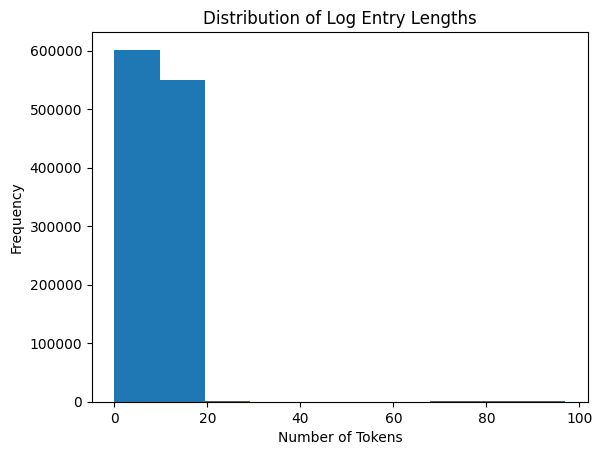

In [3]:
import matplotlib.pyplot as plt
model, tokenizer = get_model_and_tokenizer()
# Example log entries

# Tokenize log entries and calculate lengths
log_entry_lengths = [len(tokenizer.tokenize(entry)) for entry in processed_entries]
print(log_entry_lengths)
# Plot the distribution of log entry lengths
plt.hist(log_entry_lengths)
plt.title("Distribution of Log Entry Lengths")
plt.xlabel("Number of Tokens")
plt.ylabel("Frequency")
plt.show()

## Get the percentil 25, 50, 75 and 90 of the length of the tokens for the tokenizer 

In [4]:
import numpy as np
# Calculate the average    length of log entries,  the maximum length and the minimum length
  
average_length = sum(log_entry_lengths) / len(log_entry_lengths)
max_length = max(log_entry_lengths) 
min_length = min(log_entry_lengths) 

print(f"Average Length: {average_length}")
print(f"Max Length: {max_length}")
print(f"Min Length: {min_length}")

# Helper function to get the 25Th, 50Th, and 75Th percentiles   
def get_percentiles(data):
    percentiles = [25, 50, 75,90]
    values = [np.percentile(data, p) for p in percentiles]
    return values
get_percentiles(log_entry_lengths)



Average Length: 10.175231782123939
Max Length: 97
Min Length: 0


[3.0, 7.0, 18.0, 18.0]

## Understanding Bert Tokenizer using percentil 90 as mas length:

I calculated the 90th percentile and determined that the optimal maximum length for the BERT tokenizer is 18 tokens. 

This enhances the efficiency of the BERT tokenizer by ensuring that most of the input sequences fit within this limit, reducing the need for excessive padding or truncation. One reason this improves efficiency is that it minimizes computational resources and memory usage, allowing for faster processing and training times.

In [29]:
# Read and preprocess log entries
log_entries = read_logs(['20240507.jrn'])
processed_entries = preprocess_logs(log_entries)
input_ids = tokenizer(processed_entries, return_tensors='pt', padding=True, truncation=True, max_length=18)
print(input_ids)
 

{'input_ids': tensor([[  101,  4487, 13102,  ...,     0,     0,     0],
        [  101, 24094,  3643,  ...,  3597, 16671,   102],
        [  101, 24094,  3643,  ...,  3597, 16671,   102],
        ...,
        [  101,  4646,  4646,  ...,     0,     0,     0],
        [  101, 12598,  2736,  ...,     0,     0,     0],
        [  101,   102,     0,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 0,  ..., 0, 0, 0]])}


### Explanation of the Components
**input_ids:** these are the token IDs corresponding to each word in the log entries. Each log entry is converted into a sequence of numbers, where each number represents a token from the BERT vocabulary.Padding tokens (usually represented by 0s) are added to make all sequences the same length (in this case, 128).

**attention_mask:** this is a binary mask that indicates which tokens are actual data (1) and which are padding (0). This helps the model differentiate between real tokens and padding during processing.

**token_type_ids:** These are used in tasks where the input consists of pairs of sentences (e.g., question-answering tasks). For single-sentence inputs, these are typically all 0s. They help the model distinguish between different segments in the input.

## Understanding BERT Embeddings and How they are generated


- Last Hidden State is recovered beacuse it contains the embeddings of the input log entries.
- The shape of the output tensor for emebedding is  torch.Size([6393, 18, 768]).  768 is the size of the hidden layer in the BERT model. 18 is the max_length that you defined before and 6393 ins the amount of entries in the log

In [5]:
log_entries = read_logs(['20240507.jrn'])
processed_entries = preprocess_logs(log_entries)
embeddings = get_embeddings(log_entries, model, tokenizer,max_length=18)
print(embeddings.shape)



torch.Size([6393, 18, 768])


### Explanation of the BERT embeddings:

The last hidden state is the output of the last layer of the BERT model. It contains the contextual embeddings of each token in the input sequence. The last hidden state is a tensor of shape (batch_size, sequence_length, hidden_size), where batch_size is the number of input sequences, sequence_length is the maximum length of the input sequences, and hidden_size is the size of the hidden layer in the BERT model. Each element in the tensor represents the contextual embedding of a token in the input sequence. The last hidden state is used as input to downstream tasks such as text classification, named entity recognition, and question answering. 

Below is a mini-diagram of How the last hidden state is generated from BERT Model:


Input Text: "Hello, this is Eduardo!"

  ↓

Tokenization: ['hello',  ','  , 'this', 'is', 'Eduardo, '!']

  ↓

Token Embeddings: [V_hello, V_, V_this, V_is, V_Eduardo, V_!]

  ↓

Positional Embeddings: [P_0, P_1, P_2, P_3, P_4, P_5]

  ↓

Segment Embeddings: [S_0, S_0, S_0, S_0, S_0, S_0]

  ↓

Final Embeddings: [V_hello + P_0 + S_0, V_, + P_1 + S_0, ..., V_? + P_5 + S_0]

  ↓

Transformer Layers

  ↓

Last Hidden State: [H_hello, H_, H_how, H_are, H_you, H_?]


## APPLY DBSCAN 

Use DBSCAN for anomaly detection by applying the algorithm to the BERT embeddings to identify anomalies. I prefer DBSCAN (Density-Based Spatial Clustering of Applications with Noise) because it effectively identifies and handles noise and outliers, labeling points that do not belong to any cluster as noise. Additionally, it can find arbitrarily shaped clusters, which is useful for data with complex shapes, and does not require specifying the number of clusters beforehand, as it automatically determines the number of clusters based on the data.

In order to apply dbscan,  the mean of the embeddings along the sequence length dimension is calculated to get a numpy array of shape: [num_entries, 768]

In [11]:
# Apply DBSCAN for anomaly detection
from sklearn.cluster import DBSCAN
import numpy as np

# To calculate the mean of the embeddings along the sequence length dimension.
embeddings_np = embeddings.mean(dim=1).numpy()

dbscan = DBSCAN(eps=0.2, min_samples=2)  
labels = dbscan.fit_predict(embeddings_np)

# Identify anomalies (entries with label -1)
anomalies = np.where(labels == -1)[0]
# count of anomalies
print(len(anomalies))
anomalies_cleaned=[]
print("Anomalous log entries:")
for idx in anomalies:
    if 'close' in log_entries[idx].lower():
        anomalies_cleaned.append(idx)
        print(log_entries[idx])
    if 'error' in log_entries[idx].lower():
        anomalies_cleaned.append(idx)
        print(log_entries[idx])
        

2905
Anomalous log entries:
 00:04:35  5004 <Error Mgr> Error notified for device CASH_DISPENSER 

 00:16:51  5004 <Error Mgr> Error notified for device CASH_DISPENSER 

 01:04:52  5004 <Error Mgr> Error notified for device CASH_DISPENSER 

 01:31:35  5004 <Error Mgr> Error notified for device CASH_DISPENSER 

 02:26:58  5004 <Error Mgr> Error notified for device CASH_DISPENSER 

 03:19:16  5004 <Error Mgr> Error notified for device CASH_DISPENSER 

 05:43:09  5004 <Error Mgr> Error notified for device CASH_DISPENSER 

 05:45:08  5011 <Error Mgr> State of (optional) device CASH_DISPENSER changed to: OPERATIONAL (1)  

 05:45:09  5011 <Error Mgr> State of (optional) device DISPENSER changed to: OPERATIONAL (1)  

 07:23:44  5004 <Error Mgr> Error notified for device CASH_DISPENSER 

 09:45:34  5004 <Error Mgr> Error notified for device CASH_DISPENSER 

 10:08:36  5004 <Error Mgr> Error notified for device CASH_DISPENSER 

 10:08:38  5016 <CashOut Agent> REACTIVATE DEVICES: CCCdmFW ADRS 

### Visualization of Clusters in a PCA Space of 2 components


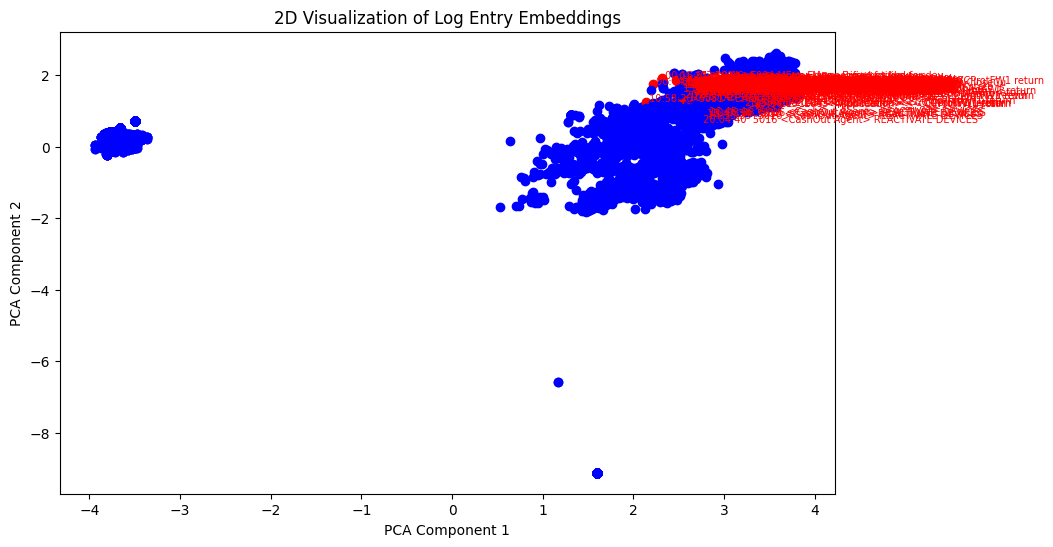

In [10]:
# Perform PCA to reduce embeddings to 2D for visualization
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings_np)

# Plot the embeddings
plt.figure(figsize=(10, 6))
for i, (x, y) in enumerate(embeddings_2d):
    if i in anomalies_cleaned:
        plt.scatter(x, y, color='red')
        try:
            plt.text(x, y, log_entries[i][:50], fontsize=7, color='red')
        except:
            pass
       
    else:
        plt.scatter(x, y, color='blue')
        #plt.text(x, y, log_entries[i], fontsize=9, color='blue')

plt.title('2D Visualization of Log Entry Embeddings')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

##  Prepare Data for Embedding Projector:

In [53]:
# Save embeddings and metadata
np.savetxt('embeddings.tsv', embeddings_np, delimiter='\t')
with open('metadata.tsv', 'w') as f:
    f.write("log_entry\tis_anomaly\n")
    for i, entry in enumerate(processed_entries):
        is_anomaly = 'yes' if i in anomalies_cleaned else 'no'
        f.write(f"{entry}\t{is_anomaly}\n")

In [54]:
# Create a config file for TensorFlow Projector
config = """
embeddings {
  tensor_path: "embeddings.tsv"
  metadata_path: "metadata.tsv"
}
"""
with open('projector_config.pbtxt', 'w') as f:
    f.write(config)